In [2]:
%pylab inline
import pandas as pd
import fastparquet 
import os,sys

Populating the interactive namespace from numpy and matplotlib


In [3]:
import lightgbm as lgb

In [4]:
if 0:
    sys.path.insert(0,os.getcwd()+"/../../src/main")
else:
    sys.path.insert(0, "/mnt/lanlep2019/src/main")
    os.environ['LOCAL']="/mnt/local"

In [5]:
!echo $LOCAL

/mnt/local


In [6]:
!mkdir -p $LOCAL/sandbox

In [7]:
HOME=os.environ['LOCAL']+"/sandbox"
os.chdir(HOME)
os.getcwd()

'/mnt/local/sandbox'

In [8]:
os.environ['LANLEP_HOME']=HOME

In [9]:
import data, utils, config

In [11]:
if 0:
    !ls /home/lizhen09/lanlep2019/input/feat/*.parq | grep -v offset_.parq | xargs -L1  -IINPUT cp INPUT {HOME}/input/feat/
else:
    !cd {HOME}/input/feat/ && cat /mnt/lizhen-east2/notebook/fastseq/5/tmp.tar | tar xf - 
    !cd {HOME}/input/feat/ && cat /mnt/lizhen-east2/notebook/fastseq/5/tmppkl.tar | tar xf -     

In [12]:
if 1:
    !cd {HOME}/input/ && cp /mnt/lizhen-east2/notebook/fastseq/5/train.parq .

In [10]:
logger=utils.get_logger("test")

In [11]:
if 1:
        fpath = config.TRAIN_PARQ
        assert utils.file_exists(fpath), fpath
        logger.info("read "+fpath)
        df = fastparquet.ParquetFile(fpath).to_pandas()
        logger.info("\n%s", df.head())
        
        a = np.diff(df.time_to_failure.values, 1)
        b = a[a > 2]
        logger.info("quake durations: " + str(b))
        logger.info("mean quake durations: " + str(np.mean(b)))
        logger.info("median quake durations: " + str(np.median(b)))
        logger.info("max quake durations: " + str(np.max(b)))
        logger.info("min quake durations: " + str(np.min(b)))
        
        pos = list(np.where(a > 2)[0])
        logger.info("quakes delimit at " + str(pos))
        for u in pos:
            assert (df.iloc[u]['time_to_failure'] < 0.01) and (df.iloc[u + 1]['time_to_failure'] > 2), "pos " + str(u)  
        
        pos = [0] + pos + [len(df)]
        quakes = []
        for i in range(len(pos) - 1):
            u = pos[i] + 1
            v = pos[i + 1] + 1
            quakes.append(df.iloc[u:v].reset_index(drop=True))
        logger.info("quake duration by 4M hz: " + str(np.round([len(u) * 1.0 / 4000000 for u in quakes], 3)))

#         for i, q in enumerate(quakes):
#             s = q.acoustic_data
#             idx = np.where(s > s.max() * 0.8)[0].max()
#             logger.info("quake {}, max signal={}, len={}, max_sig_time={}".format(i, s.max(), (len(s) - idx), q.iloc[idx]['time_to_failure']))

#         for i, q in enumerate(quakes):
#             outfname = os.path.join(config.INPUT_PATH, "quake_{}.parq".format(i))
#             logger.info("write {}".format(outfname))
#             logger.info("\n%s", q.head())
#             fastparquet.write(outfname, q , compression='SNAPPY')


2019-04-15 10:19:20,615 - test - INFO - read /mnt/local/sandbox/input/train.parq
2019-04-15 10:19:33,402 - test - INFO - 
   acoustic_data  time_to_failure
0             12           1.4691
1              6           1.4691
2              8           1.4691
3              5           1.4691
4              8           1.4691
2019-04-15 10:19:34,210 - test - INFO - quake durations: [11.540005  14.179905   8.855905  12.692904   8.054905   7.0579047
 16.106905   7.9049044  9.636905  11.425904  11.024005   8.828005
  8.565905  14.750904   9.458905  11.618005 ]
2019-04-15 10:19:34,212 - test - INFO - mean quake durations: 10.731367
2019-04-15 10:19:34,213 - test - INFO - median quake durations: 10.330455
2019-04-15 10:19:34,215 - test - INFO - max quake durations: 16.106905
2019-04-15 10:19:34,216 - test - INFO - min quake durations: 7.0579047
2019-04-15 10:19:34,816 - test - INFO - quakes delimit at [5656573, 50085877, 104677355, 138772452, 187641819, 218652629, 245829584, 307838916, 338276

In [12]:
df['rt']=df.index[::-1]

In [13]:
df['cumpower2']=(df['acoustic_data'].iloc[::-1]**2).cumsum()[::-1]

In [14]:
df['power2']=df['acoustic_data']**2

In [15]:
df.head()

acoustic_data  time_to_failure         rt    cumpower2  power2
0             12           1.4691  629145479  85363086056     144
1              6           1.4691  629145478  85363085912      36
2              8           1.4691  629145477  85363085876      64
3              5           1.4691  629145476  85363085812      25
4              8           1.4691  629145475  85363085787      64

In [16]:
delimits = dict(enumerate([u +1 for u in pos]))
del delimits[0],delimits[17],delimits[16]
str(delimits)

'{1: 5656574, 2: 50085878, 3: 104677356, 4: 138772453, 5: 187641820, 6: 218652630, 7: 245829585, 8: 307838917, 9: 338276287, 10: 375377848, 11: 419368880, 12: 461811623, 13: 495800225, 14: 528777115, 15: 585568144}'

In [17]:
lst=[]
for i in range(1,15):
    a=df.iloc[delimits[i]]['time_to_failure']
    b=delimits[i+1]-delimits[i]
    print a/b
    lst.append(a/b)
tick_per_sec=np.mean(lst)    
print 'mean', tick_per_sec

2.597564907747484e-07
2.597584950222597e-07
2.59764620805815e-07
2.5975372760896666e-07
2.597642573837181e-07
2.597421239891956e-07
2.597576908934455e-07
2.5973334985753926e-07
2.5974918466979224e-07
2.597438538070975e-07
2.597428832404429e-07
2.597370790498466e-07
2.597576661941502e-07
2.597558072672897e-07
mean 2.597512307545933e-07


In [18]:
da=df['acoustic_data'].values
df.iloc[np.where(da>4000)]['time_to_failure'].describe()

count    35.000000
mean      0.316252
std       0.003373
min       0.311198
25%       0.314698
50%       0.315497
75%       0.320300
max       0.320300
Name: time_to_failure, dtype: float64

In [19]:
zero_failure_to_peak_sec=0.315497

In [20]:
dt = -df['time_to_failure'].diff(1)

In [21]:
np.where(dt>1)

(array([], dtype=int64),)

In [22]:
dt.mean(),dt.median()

(-1.31777504e-08, 0.0)

In [23]:
a=dt[dt>=0]
a=a[a<1]
a.mean(),a.median()

(2.5972275e-07, 0.0)

In [24]:
df['power2'].mean(),df['power2'].median()

(135.6809971137359, 25.0)

In [25]:
a=df['power2'][df['power2']<1000**2]
a.mean(),a.median()

(83.73878680308145, 25.0)

In [26]:
#k1-25=k2*2.5972275e-07

In [27]:
#k2=-(132.702223-25)/2.5972275e-07
#k2

In [28]:
if 1:
    a = fastparquet.ParquetFile("./input/feat/dense_train_seq_fwv_offset_0.parq").to_pandas()
    b = fastparquet.ParquetFile("./input/feat/dense_train_seq_fwv_offset_125.parq").to_pandas()
    traintest=(a+b)/2

In [29]:
traintest.sort_index().head()

fwv_0     fwv_1     fwv_2     fwv_3     fwv_4  \
index                                                                    
quake_00_0000_000000  0.216542  0.185661  0.108143 -0.078809  0.072412   
quake_00_0000_001500  0.216926  0.186926  0.107084 -0.078361  0.072662   
quake_00_0000_003000  0.218769  0.185365  0.107872 -0.077107  0.068210   
quake_00_0000_004500  0.217223  0.187727  0.107976 -0.075922  0.069759   
quake_00_0000_006000  0.217587  0.189069  0.109821 -0.078284  0.067517   

                         fwv_5     fwv_6     fwv_7     fwv_8     fwv_9  \
index                                                                    
quake_00_0000_000000 -0.139160 -0.031245  0.159314  0.176967  0.008096   
quake_00_0000_001500 -0.141274 -0.032242  0.155919  0.177656  0.008914   
quake_00_0000_003000 -0.144663 -0.027850  0.152220  0.177217  0.014360   
quake_00_0000_004500 -0.149111 -0.028620  0.147861  0.177286  0.021192   
quake_00_0000_006000 -0.148003 -0.027025  0.151348  0.174712  0.022093   

                        ...       fwv_91    fwv_92    fwv_93    fwv_94  \
index                   ...                                              
quake_00_0000_000000    ...     0.211306  0.132915  0.057632 -0.069395   
quake_00_0000_001500    ...     0.212022  0.133815  0.060779 -0.068313   
quake_00_0000_003000    ...     0.213136  0.137043  0.060594 -0.067772   
quake_00_0000_004500    ...     0.210489  0.139401  0.061828 -0.065347   
quake_00_0000_006000    ...     0.209734  0.137879  0.058090 -0.065387   

                        fwv_95    fwv_96    fwv_97    fwv_98    fwv_99  \
index                                                                    
quake_00_0000_000000  0.011235 -0.035435 -0.102105  0.053612  0.032469   
quake_00_0000_001500  0.015169 -0.034959 -0.099313  0.053454  0.029014   
quake_00_0000_003000  0.017519 -0.036653 -0.097048  0.052951  0.025466   
quake_00_0000_004500  0.015690 -0.038876 -0.095629  0.053188  0.021562   
quake_00_0000_006000  0.018760 -0.038393 -0.095949  0.053929  0.024904   

                             y  
index                           
quake_00_0000_000000  1.430797  
quake_00_0000_001500  1.430796  
quake_00_0000_003000  1.429798  
quake_00_0000_004500  1.429797  
quake_00_0000_006000  1.428700  

[5 rows x 101 columns]

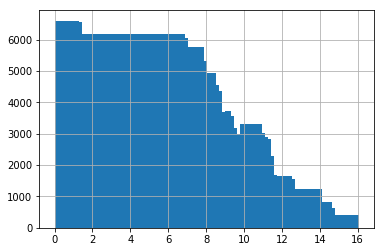

In [30]:
traintest.y.hist(bins=100);

In [31]:
np.abs(traintest.y-traintest.y.median()).mean()

3.02918898210172

In [32]:
traindf=traintest.drop('y',axis=1)
ydf=traintest.y
qdf=traindf.index.map(lambda u: int(u.split("_")[1]))

In [33]:
idx=~qdf.isin({0,16})
traindf=traindf[idx]
ydf=ydf[idx]
qdf=qdf[idx]

In [34]:
def f(u):
    qno, i, offset = [int(x) for x in u.split('_')[1:]]
    return delimits[qno]+offset+(i+0)*150 * 1000
    
globaloffset = pd.Series(traindf.index.map(f), index=traindf.index) 

In [35]:
ydf.shape,traindf.shape

((409394,), (409394, 100))

In [36]:
df.head()

acoustic_data  time_to_failure         rt    cumpower2  power2
0             12           1.4691  629145479  85363086056     144
1              6           1.4691  629145478  85363085912      36
2              8           1.4691  629145477  85363085876      64
3              5           1.4691  629145476  85363085812      25
4              8           1.4691  629145475  85363085787      64

In [37]:
BT0=df.loc[globaloffset.values,'cumpower2'].values

In [38]:
BT0

array([67883408888, 53438798663, 46698136638, ..., 42315947099,
       11489617842, 27264942038])

In [39]:
T0=df.loc[globaloffset.values,'rt'].values

In [40]:
BT0.shape,T0.shape

((409394,), (409394,))

In [41]:
traindf.shape

(409394, 100)

In [42]:
H=np.concatenate([traindf.values,np.ones([len(traindf),1]), -T0.reshape([-1,1])],axis=1)

In [43]:
H.shape,BT0.shape

((409394, 102), (409394,))

In [44]:
x,residuals,rank,s = np.linalg.lstsq(H, -BT0)

/home/hadoop/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if __name__ == '__main__':


In [45]:
from sklearn.linear_model import LinearRegression
reg=LinearRegression().fit(H,-BT0)
reg.score(H,-BT0)

0.9994258608045067

In [46]:
x

array([-2.09444581e+09, -6.70539539e+08, -1.18631089e+09, -1.03979416e+08,
        3.74207119e+08, -3.26960878e+07, -3.59542684e+08, -6.90431564e+08,
       -1.10278627e+09, -4.62501866e+08, -2.81681757e+09, -5.83135238e+08,
        8.05275281e+08,  1.07668970e+09,  1.14897361e+09, -1.35609111e+09,
        1.63148469e+08, -1.21516034e+09,  8.18935780e+08,  8.49409193e+08,
       -3.57953517e+08,  2.08282939e+09,  2.68033858e+09, -7.60853935e+08,
       -8.55076965e+08,  2.31350758e+08,  2.38509705e+09,  1.04891685e+09,
        1.83789422e+09,  1.58440635e+09, -5.74431532e+08, -2.12566269e+09,
        1.46765607e+09, -1.79845381e+09,  1.75871869e+09, -1.32697778e+09,
        8.22259400e+08, -3.43942747e+08,  6.44542375e+08, -1.34623718e+09,
       -2.04745430e+09, -3.74506267e+08,  7.98431112e+08,  3.02081592e+08,
        1.16924338e+09, -1.23089516e+09,  3.19521062e+08, -3.00136063e+09,
        2.16468151e+08, -1.81110538e+09, -3.43281647e+08, -4.66149283e+08,
       -6.74504455e+08,  

In [47]:
x.shape

(102,)

In [48]:
alpha_prime=x[:100]
beta_prime=x[100]
k1=x[101]

In [49]:
beta_prime,k1

(3461614266.50549, 132.70222306251526)

In [50]:
delimits

{1: 5656574,
 2: 50085878,
 3: 104677356,
 4: 138772453,
 5: 187641820,
 6: 218652630,
 7: 245829585,
 8: 307838917,
 9: 338276287,
 10: 375377848,
 11: 419368880,
 12: 461811623,
 13: 495800225,
 14: 528777115,
 15: 585568144}

In [51]:
tmp=ydf.to_frame().reset_index()
tmp['qno']=qdf
tmp=tmp[tmp['y']>=zero_failure_to_peak_sec]
tmp=tmp.sort_values(['qno','y'])

In [52]:
minsegs = tmp.groupby("qno").head(1).set_index('index')['y']
minsegs

index
quake_01_0287_016500    0.315596
quake_02_0354_129000    0.315696
quake_03_0218_031500    0.315997
quake_04_0316_105000    0.315498
quake_05_0197_097500    0.315996
quake_06_0172_009000    0.316497
quake_07_0404_046500    0.315596
quake_08_0193_120000    0.316196
quake_09_0238_037500    0.315497
quake_10_0284_024000    0.316196
quake_11_0273_126000    0.316096
quake_12_0217_072000    0.316096
quake_13_0210_114000    0.315796
quake_14_0369_078000    0.315596
quake_15_0233_105000    0.315596
Name: y, dtype: float64

In [53]:
k1

132.70222306251526

In [54]:
k2=k1-135.6809971137359
#k2=k1-83.73878680308145
#k2=k1-25
k2

-2.978774051220654

In [55]:
alpha=alpha_prime/k2
alpha

array([ 7.03123424e+08,  2.25105875e+08,  3.98254742e+08,  3.49067820e+07,
       -1.25624540e+08,  1.09763571e+07,  1.20701563e+08,  2.31783798e+08,
        3.70214812e+08,  1.55265844e+08,  9.45629818e+08,  1.95763501e+08,
       -2.70337819e+08, -3.61453969e+08, -3.85720298e+08,  4.55251419e+08,
       -5.47703405e+07,  4.07939750e+08, -2.74923766e+08, -2.85153952e+08,
        1.20168066e+08, -6.99223692e+08, -8.99812652e+08,  2.55425192e+08,
        2.87056672e+08, -7.76664341e+07, -8.00697537e+08, -3.52130383e+08,
       -6.16996855e+08, -5.31898803e+08,  1.92841593e+08,  7.13603200e+08,
       -4.92704733e+08,  6.03756372e+08, -5.90416951e+08,  4.45477823e+08,
       -2.76039534e+08,  1.15464530e+08, -2.16378404e+08,  4.51943370e+08,
        6.87347972e+08,  1.25724966e+08, -2.68040173e+08, -1.01411382e+08,
       -3.92525032e+08,  4.13222064e+08, -1.07265961e+08,  1.00758251e+09,
       -7.26702150e+07,  6.08003612e+08,  1.15242593e+08,  1.56490313e+08,
        2.26436931e+08, -

In [56]:
beta_prime

3461614266.50549

In [57]:
X=np.sum(alpha*traindf.loc[minsegs.index].values,1)
X

array([1.84225361e+09, 1.84369175e+09, 1.87963708e+09, 1.94260143e+09,
       1.77010037e+09, 1.77229003e+09, 1.87957728e+09, 2.03297936e+09,
       1.82497259e+09, 1.87810476e+09, 2.03930441e+09, 1.77777502e+09,
       1.86804530e+09, 1.98469590e+09, 1.79659427e+09])

In [58]:
beta=-X.mean()
print beta
beta=beta*1.073
print beta

-1875508211.0673344
-2012420310.4752498


In [59]:
A=k2*beta-beta_prime
A,k2,k1

(2532931134.487596, -2.978774051220654, 132.70222306251526)

In [60]:
df.head()

acoustic_data  time_to_failure         rt    cumpower2  power2
0             12           1.4691  629145479  85363086056     144
1              6           1.4691  629145478  85363085912      36
2              8           1.4691  629145477  85363085876      64
3              5           1.4691  629145476  85363085812      25
4              8           1.4691  629145475  85363085787      64

In [61]:
a=(A+df['rt']*k1-df['cumpower2'])/k2/30

In [62]:
b=a[globaloffset.values].values*tick_per_sec

In [63]:
from sklearn.linear_model import LinearRegression

coef [-1.01106346] 2.613261391994011
range 1 -10.23143272401197 -1.1833200012995782 9.048112722712393


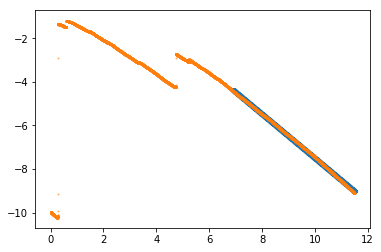

coef [-1.00212078] 4.3698108566913
range 2 -9.93194058841282 -1.1349694553766598 8.796971133036159


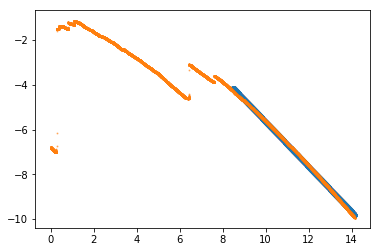

coef [-1.03920592] 2.46766365807646
range 3 -7.43215677200836 -0.38742106752392347 7.044735704484437


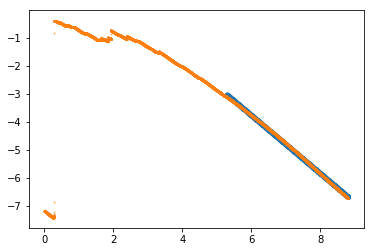

coef [-0.98293583] 5.388320384306106
range 4 -7.524919691918014 1.0153693833743502 8.540289075292364


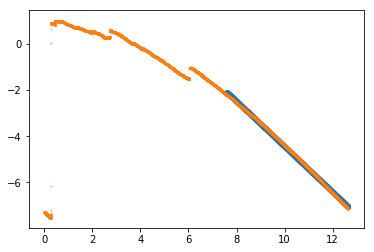

coef [-1.05532725] 1.2481623248494778
range 5 -8.128661702012323 -0.49294529464953735 7.635716407362786


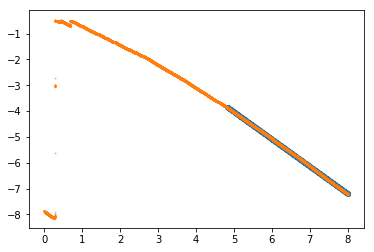

coef [-1.00695785] -0.7272337151306365
range 6 -10.978040256096016 -3.0559969022246403 7.922043353871375


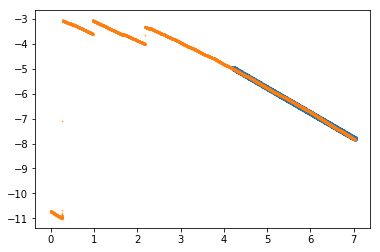

coef [-1.00868062] 5.6693153663077
range 7 -10.670088563536305 -0.2795153987208131 10.390573164815493


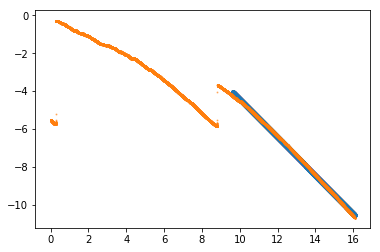

coef [-1.04923569] 2.786883108129571
range 8 -7.00352832657341 1.1872820354154825 8.190810361988893


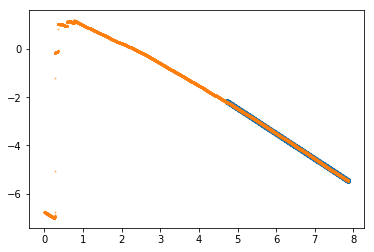

coef [-1.03740127] 3.255194537548194
range 9 -9.004589978720714 1.2540166069423226 10.258606585663037


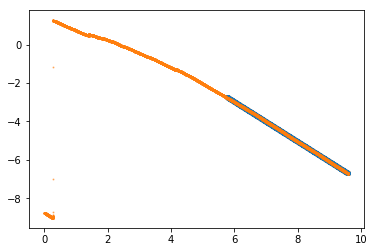

coef [-1.00757764] 2.8395697793866574
range 10 -8.698529911240069 -0.06723923204147782 8.63129067919859


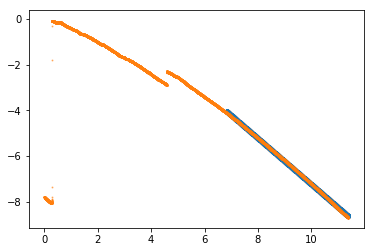

coef [-0.99371346] 3.2291247348117853
range 11 -7.761890458171938 0.6134489231780708 8.375339381350008


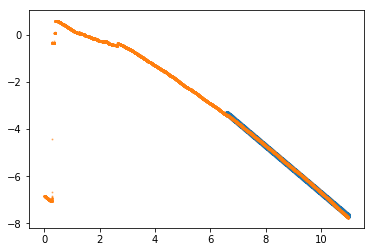

coef [-1.00863078] 2.114933983622561
range 12 -10.531657478485958 -0.16025826887581354 10.371399209610145


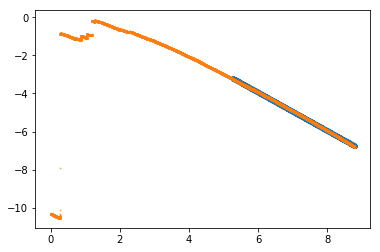

coef [-1.04265983] -1.3685731912086085
range 13 -10.265131200580088 -2.805260364738031 7.459870835842057


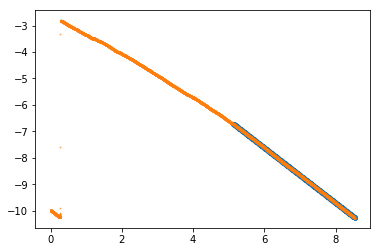

coef [-0.97978473] 4.587353337339864
range 14 -9.940180461837208 -0.8995047082509356 9.040675753586273


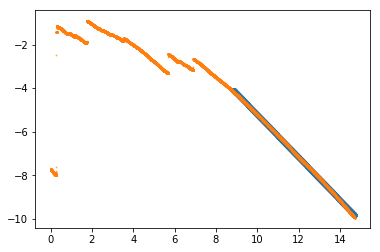

coef [-1.09486595] 2.681347482124056
range 15 -9.721251671638976 -1.250017766140384 8.471233905498591


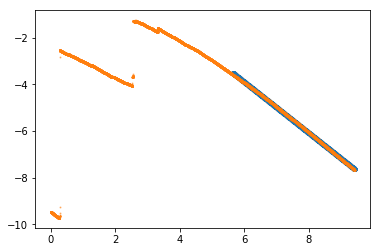

In [64]:
for qno in range(1,16):
    idx=qdf==qno
    bb=b[idx]
    aa=ydf.values[idx]
    if 1:
        sidx=np.argsort(aa)
        bb=bb[sidx]
        aa=aa[sidx]
    if 1:
        n=int(len(aa)*0.4)
        model = LinearRegression().fit(aa[-n:].reshape(-1, 1),bb[-n:])
        print 'coef', model.coef_, model.intercept_
        pbb=model.predict(aa[-n:].reshape(-1, 1))
        plt.scatter(aa[-n:].reshape(-1, 1),pbb,s=11)
    print 'range', qno,bb.min(),bb.max(), bb.max()-bb.min()
    plt.scatter(aa,bb,s=1,alpha=0.5)
    plt.show()

In [65]:
b=np.sum(traindf.values*alpha,1)+beta
b=b*tick_per_sec/25+8

1


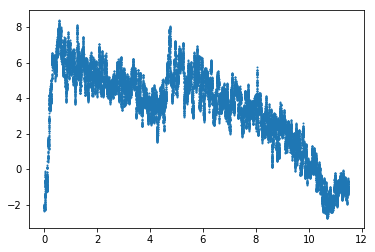

2


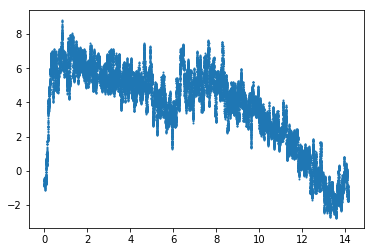

3


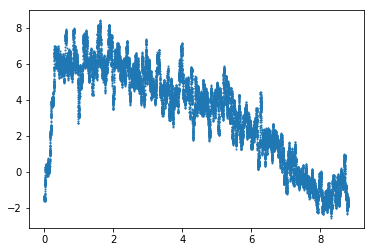

4


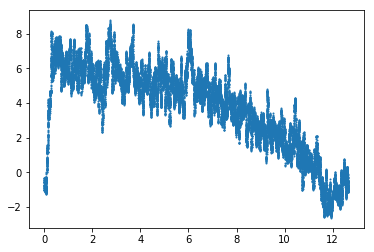

5


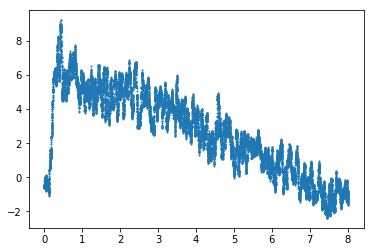

6


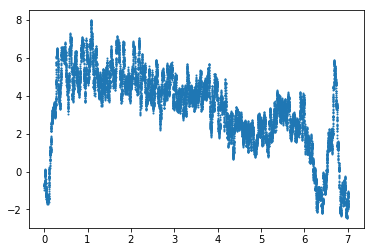

7


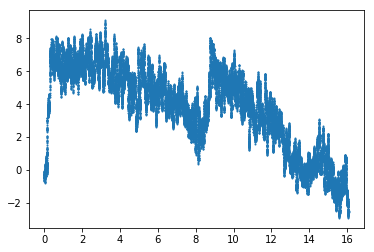

8


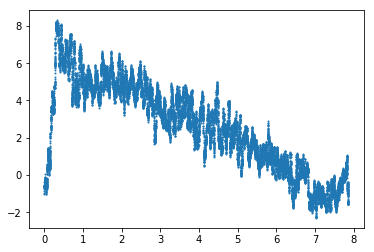

9


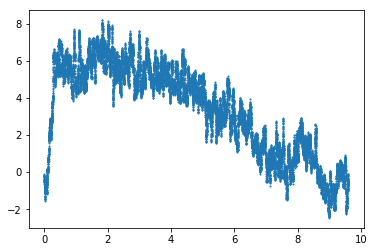

10


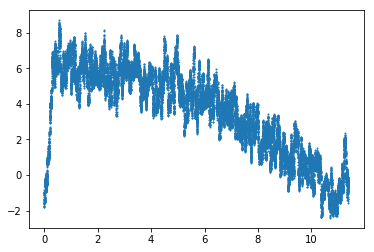

11


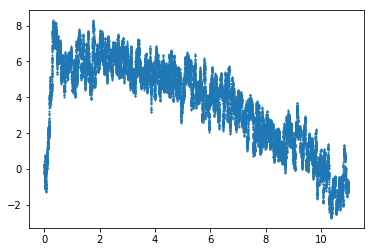

12


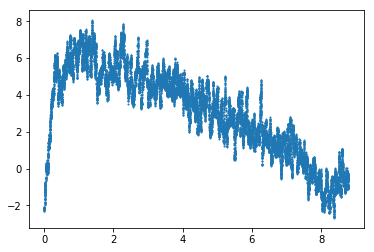

13


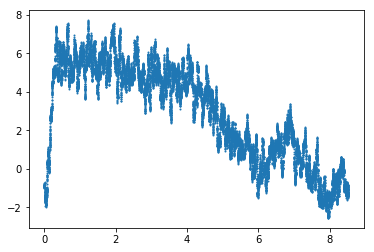

14


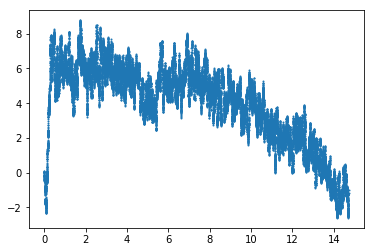

15


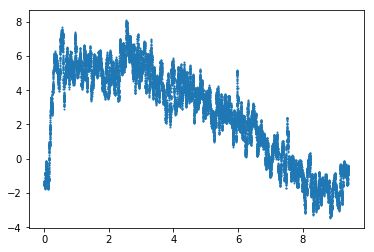

In [66]:
for qno in range(1,16):
    idx=qdf==qno
    print qno
    plt.scatter(ydf.values[idx],b[idx],s=1)
    plt.show()

In [67]:
import gc
gc.collect()

26207

In [45]:
from sklearn.linear_model import LinearRegression, Ridge,Lasso


In [122]:
reg = LinearRegression(fit_intercept=False).fit(H,BT0)


In [121]:
reg.score(H,BT0)

0.9994258605930015

In [119]:
reg.score(H,BT0)

0.9994258605929971

In [116]:
reg.intercept_

5335697564.480194

In [108]:
residuals[0]

1.3103301300606225e+23

In [112]:
1.3103301300606225e+23/np.sum((BT0-BT0.mean())**2)

0.000574139406994869

((409394, 102), (409394,))

In [48]:
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

In [49]:
colors= [
        "FF0000", "00FF00", "0000FF", "FF00FF", "00FFFF", "000000", 
        "800000", "008000", "000080", "808000", "800080", "008080", "808080", 
        "C00000", "00C000", "0000C0", "C0C000", "C000C0", "00C0C0", "C0C0C0", 
        "400000", "004000", "000040", "404000", "400040", "004040", "404040", 
        "200000", "002000", "000020", "202000", "200020", "002020", "202020", 
        "600000", "006000", "000060", "606000", "600060", "006060", "606060", 
        "A00000", "00A000", "0000A0", "A0A000", "A000A0", "00A0A0", "A0A0A0", 
        "E00000", "00E000", "0000E0", "E0E000", "E000E0", "00E0E0", "E0E0E0", 
    ]
colors=[np.array([int(h[i:i+2], 16)/255.0 for i in (0, 2 ,4)]) for h in colors]

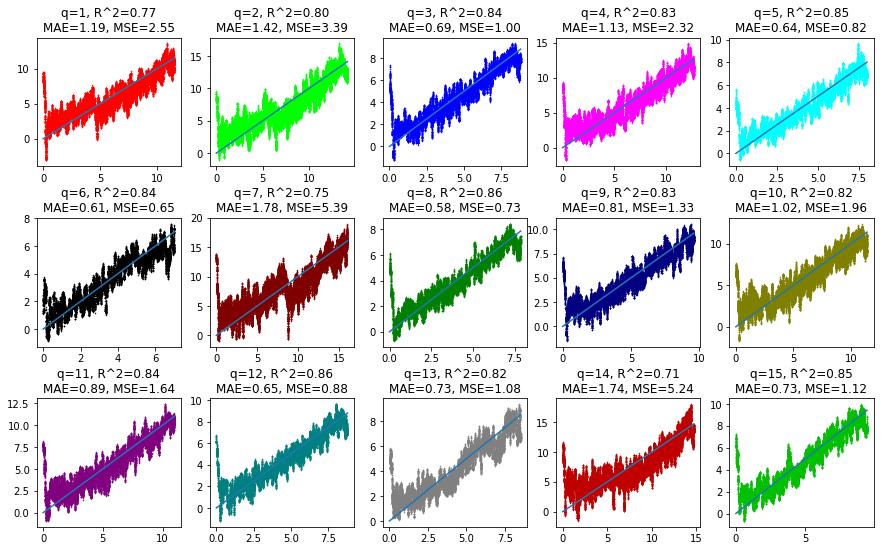

In [50]:
fig, axs = plt.subplots(figsize=(15,9), 
                        nrows=3, ncols=5,     # fix as above
                        gridspec_kw=dict(hspace=0.4)) # Much control of gridspec

references=sorted(set(qdf))

for ax, (i,qno) in zip(axs.flatten(), enumerate(references)):
    X=traindf[qdf==qno]
    Y=ydf[qdf==qno]
    reg = Ridge().fit(X,Y)
    x,y=Y,reg.predict(X)
    ax.scatter(x.values,y,s=0.3,c=colors[i])
    b=sorted(x.values)
    ax.plot(b,b)
    ax.set_title('q={}, R^2={:.2f}\nMAE={:.2f}, MSE={:.2f}'.format(qno,r2_score(x,y), mean_absolute_error(x,y)
                                                                   ,mean_squared_error(x,y)))
    

In [41]:
#! cd /mnt && tar xf /mnt/lizhen-east2/notebook/fastseq/5/trainqs.tar

In [35]:
def readq(qno):
    return fastparquet.ParquetFile("/mnt/quake_{}.parq".format(qno)).to_pandas()

In [58]:
q=readq(14)

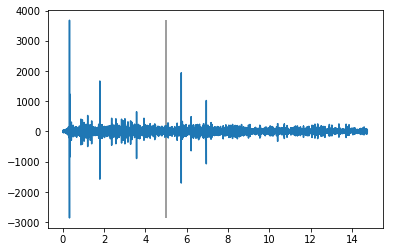

In [59]:
plt.plot(q.time_to_failure, q.acoustic_data);
plt.vlines(x=5,ymin=q.acoustic_data.min(), ymax=q.acoustic_data.max(),alpha=0.5);

In [42]:
reg = LinearRegression().fit(traindf, ydf)

In [43]:
reg.score(traindf,ydf)

0.47749277921675126

In [44]:
trainpred=reg.predict(traindf)

In [45]:
err=ydf.values-trainpred
np.sqrt(np.mean(err*err)),np.sqrt(np.median(np.abs(err)))

(2.6242166651851453, 1.3087841294000262)

In [46]:
a=ydf.copy().to_frame()
a['pred']=trainpred
a['abserr']=np.abs(a['pred']-a['y'])
a['qno']=a.index.map(lambda u: int(u.split("_")[1]))

In [47]:
a.groupby('qno')['abserr'].apply(lambda u: np.sqrt(np.mean(u.values**2))).sort_values()

qno
11    1.631354
9     1.644194
10    1.805674
12    1.875820
1     1.888808
3     1.897652
15    2.231170
13    2.233907
4     2.364902
5     2.658899
8     2.727387
6     2.837420
2     3.057987
14    3.505263
7     4.003069
Name: abserr, dtype: float64

In [48]:
a.groupby('qno')['abserr'].apply(lambda u:  np.mean(u.values)).sort_values()

qno
9     1.134728
11    1.205874
10    1.388971
3     1.443394
12    1.443830
1     1.481676
15    1.782918
13    1.812713
4     1.998983
5     2.332561
8     2.474056
6     2.487523
2     2.559095
14    2.991004
7     3.303495
Name: abserr, dtype: float64

In [49]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

In [50]:
colors= [
        "FF0000", "00FF00", "0000FF", "FF00FF", "00FFFF", "000000", 
        "800000", "008000", "000080", "808000", "800080", "008080", "808080", 
        "C00000", "00C000", "0000C0", "C0C000", "C000C0", "00C0C0", "C0C0C0", 
        "400000", "004000", "000040", "404000", "400040", "004040", "404040", 
        "200000", "002000", "000020", "202000", "200020", "002020", "202020", 
        "600000", "006000", "000060", "606000", "600060", "006060", "606060", 
        "A00000", "00A000", "0000A0", "A0A000", "A000A0", "00A0A0", "A0A0A0", 
        "E00000", "00E000", "0000E0", "E0E000", "E000E0", "00E0E0", "E0E0E0", 
    ]
colors=[np.array([int(h[i:i+2], 16)/255.0 for i in (0, 2 ,4)]) for h in colors]

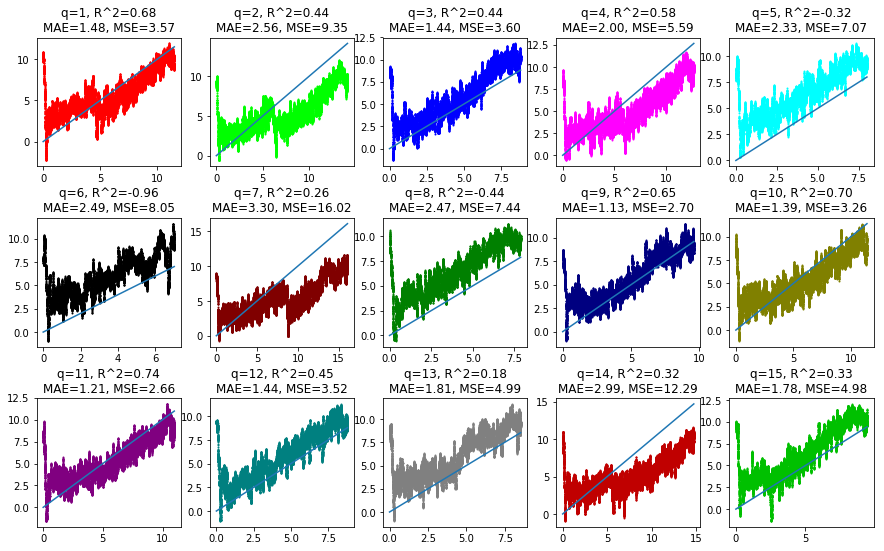

In [51]:
fig, axs = plt.subplots(figsize=(15,9), 
                        nrows=3, ncols=5,     # fix as above
                        gridspec_kw=dict(hspace=0.4)) # Much control of gridspec

references=sorted(set(a['qno']))

for ax, (i,qno) in zip(axs.flatten(), enumerate(references)):
    x,y=a[a['qno']==qno]['y'],a[a['qno']==qno]['pred']
    ax.scatter(x,y,s=1,c=colors[i])
    b=sorted(x.values)
    ax.plot(b,b)
    ax.set_title('q={}, R^2={:.2f}\nMAE={:.2f}, MSE={:.2f}'.format(qno,r2_score(x,y), mean_absolute_error(x,y)
                                                                   ,mean_squared_error(x,y)))
    